In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import RectBivariateSpline
from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale, rotate

# Analytic Reconstruction Methods

Consider the following setup

<p align="center">
  <img src="..\images\sacnner.PNG" alt="drawing" width="500" align="center"/>
</p>

An object with unknown attenuation coefficient $\mu(x,y)$ can be scanned in multiple positions. During scanning, photons are sent through the object and the resulting intensity is picked up by a scanner. It is known that

$$I = I_0 e^{-\int \mu(x,y)ds}$$

where $ds$ is a particular straight line through the object. If is more useful to write

$$\ln(I_0/I) = \int \mu(x,y)ds$$ 

The quantity on the left can be measured for a variety of scanner positions. Shown above are two possible scanner positions with corresponding values of $\ln(I_0/I)$. 

For the rest of this we will call 

* $\mu(x,y)=f(x,y)$ 
* $\ln(I_0/I)=p(r,\theta)$.

The parameters are as follows:

* The parameter $\theta$ species the tilt of the scanner (i.e. scanner 1 at $\theta=90^{\circ}$  and scanner 2 at $\theta=-45^{\circ})$. 
* The parameter $r$ specifies the horizontal location on the the scanner (i.e. scanner 1 measures largest value at $r=0$ and decays as $r\to \pm$)

**The goal is to reconstruct $f(x,y)$ given $p(r, \theta)$**

We'll start with $f(x,y)$, use this to get $p(r,\theta)$, and then look at techniques to reobtain $f(x,y)$ from $p(r,\theta)$

In [2]:
#image = shepp_logan_phantom()
image = np.ones([100,100])
# Resize Image
diag = len(np.diag(image)//2)
image = np.pad(image, pad_width=diag+10)

Define a meshgrid of $x$ and $y$ values that correspond to coordinates of the square. $x=0$ and $y=0$ correspond to the point of rotation

In [4]:
_ = np.linspace(-1, 1, image.shape[0])
xv, yv = np.meshgrid(_,_)
image[(xv-0.1)**2+(yv-0.2)**2<0.01] = 2

# Create a rotated image
image_rot = rotate(image, 45)

Plot the square and its rotation

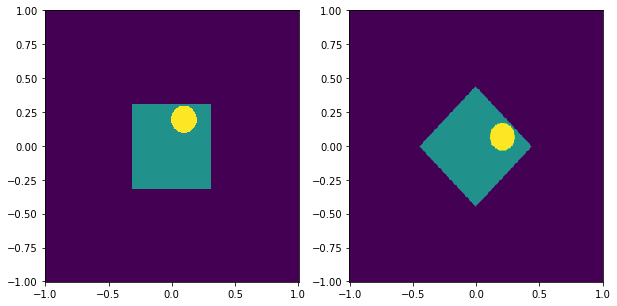

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].pcolor(xv,yv,image, shading='auto')
ax[1].pcolor(xv,yv,image_rot, shading='auto')
plt.show()

The rotated squares will allow us to get $p(r,\theta)$ for a variety of $\theta$s. Let's Create a bunch of different rotations for a bunch of different $\theta$s

In [61]:
thetas = np.arange(0,180,5) * np.pi/180
rs = _
dtheta = np.diff(thetas)[0]
dr = np.diff(rs)[0]
rotations = np.array([rotate(image, theta*180/np.pi) for theta in thetas])

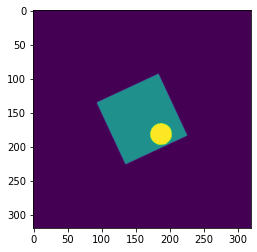

In [62]:
plt.imshow(rotations[5])

Define $p(r,\theta)$: the sinogram. This involves summing each rotated image about the vertical axis (which gives a distribution $g(r)$ for each image) for each value of $\theta$ (which then gives a net function $p(r,\theta)$)

In [63]:
p = np.array([rotation.sum(axis=0)*dr for rotation in rotations]).T

Plot the scan at a given angle

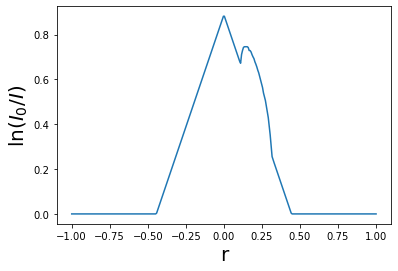

In [128]:
plt.plot(rs, p[:,9])
plt.xlabel('r', fontsize=20)
plt.ylabel('$\ln(I_0/I)$', fontsize=20)
plt.show()

Plot the sinogram

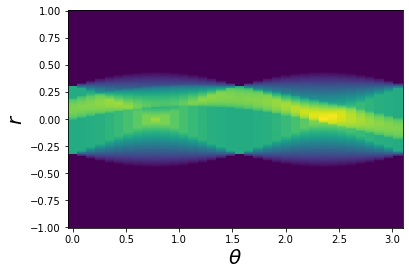

In [65]:
plt.pcolor(thetas, rs, p, shading='auto')
plt.xlabel(r'$\theta$', fontsize=20)
plt.ylabel('$r$', fontsize=20)
plt.show()

# Regular back projection:

For a scan at angle $\theta$, the value of $r$ that the point $(x,y)$ contributes is $x\cos\theta + y\sin\theta$. 

$$f_{\text{BP}}(x,y) = \int_{0}^{\pi} p(x\cos\theta+y\sin\theta, \theta)d\theta \approx \sum_i p(x\cos\theta_i+y\sin\theta_i, \theta_i) \Delta \theta_i$$

Function that provides an interpolation of the sinogram above

In [66]:
p_interp = RectBivariateSpline(rs, thetas, p)

Define $f_{\text{BP}}$

In [67]:
def get_fBP(x,y):
    return p_interp(x*np.cos(thetas)+y*np.sin(thetas), thetas, grid=False).sum() * dtheta

fBP = np.vectorize(get_fBP)(xv,yv)

Plot the regularily back-projected image

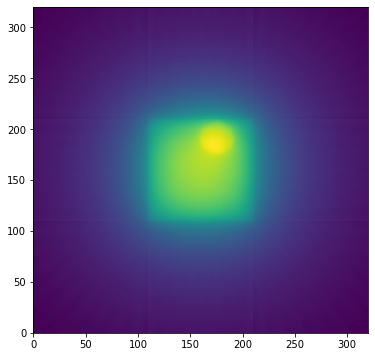

In [68]:
plt.figure(figsize=(6,6))
plt.pcolor(fBP)
plt.show()

# Filtered Back Projection

This makes use of Fourier domain information

* $f(x,y)$ has 2D Fourier transform $$F(\nu_x, \nu_y) =\iint dx dy f(x,y)e^{j2\pi \nu_x x}e^{j2\pi \nu_y y}$$
* $p(r,\theta)$ has 1D Fourier transform $$P(\nu, \theta) = \int p(r,\theta)e^{j2\pi \nu r} dr$$

It follows that

$$F(\nu\cos\theta, \nu\sin\theta) =\iint dxdy f(x,y) e^{j2\pi x \nu\cos\theta}e^{j2\pi y \nu\sin\theta}$$

Let $r=x\cos\theta+y\sin\theta$. This is the equation for a line (moves parallel to scanner direction when changing $r$). Also let $t=-x\cos\theta+y\sin\theta$ be a line perpendicular to this (moves perpendicular to the scanner direction when changing $t$). Then 

$$F(\nu\cos\theta, \nu\sin\theta) =\iint drdt f(x,y) e^{j2\pi r \nu} = \int dr \left[ \int f(x,y) dt \right] e^{j2\pi r \nu} = \int dr p(r,\theta)e^{j2\pi r \nu} = P(\nu,\theta) $$

In other words, the 2D fourier transform of $f(x,y)$ is related to the 1D fourier transform of the radon function $p(r,\theta)$

$$\boxed{F(\nu\cos\theta, \nu\sin\theta) = P(\nu,\theta)}$$

So given the radon transform (which we have) we can do filtering in the Fourier space, then take the inverse 2D transform to get $f(x,y)$. Using this, we can explictly solve for $f(x,y)$:


<p align="center">
  <img src="..\images\fbp.PNG" alt="drawing" width="500" align="center"/>
</p>


In [129]:
from scipy.fft import fft, ifft

Get stuff

In [130]:
P = fft(p, axis=0)
nu = np.fft.fftfreq(P.shape[0], d=np.diff(rs)[0])

In [131]:
P.T.shape

(36, 320)

In [132]:
nu.shape

(320,)

In [153]:
integrand = P.T * np.abs(nu)
integrand = integrand.T
p_p = np.real(ifft(integrand, axis=0))

In [154]:
p_p_interp = RectBivariateSpline(rs, thetas, p_p)

In [155]:
def get_f(x,y):
    return p_p_interp(x*np.cos(thetas)+y*np.sin(thetas), thetas, grid=False).sum() * dtheta

f = np.vectorize(get_f)(xv,yv)

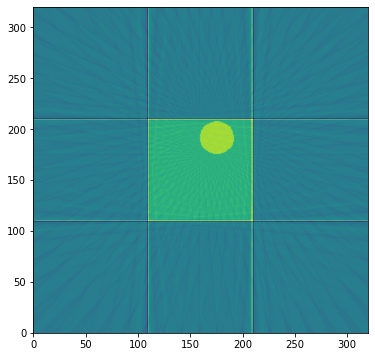

In [156]:
plt.figure(figsize=(6,6))
plt.pcolor(f)
plt.show()

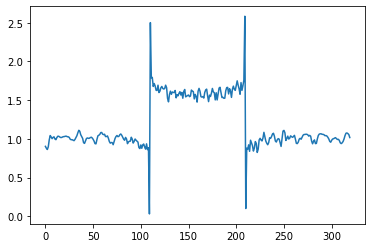

In [157]:
plt.plot(f[110])

# With SkImage Libraries

In [170]:
from skimage.transform import radon, iradon

In [172]:
theta = np.arange(0., 180., 5)
sinogram = radon(image, theta=theta)

C:\Users\lukep\anaconda3\lib\site-packages\skimage\transform\radon_transform.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  coords = np.array(np.ogrid[:image.shape[0], :image.shape[1]])


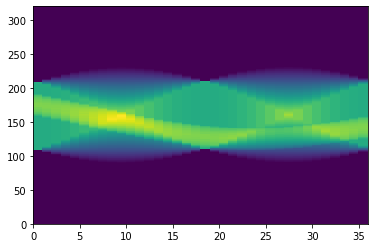

In [173]:
plt.pcolor(sinogram)

In [174]:
reconstruction_img = iradon(sinogram, theta=theta, filter_name='ramp')

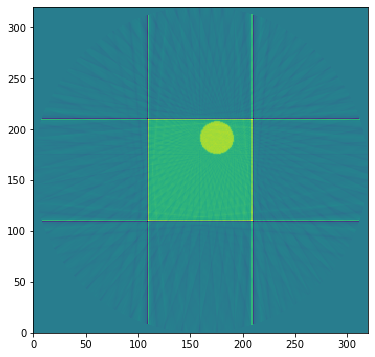

In [175]:
plt.figure(figsize=(6,6))
plt.pcolor(reconstruction_img)

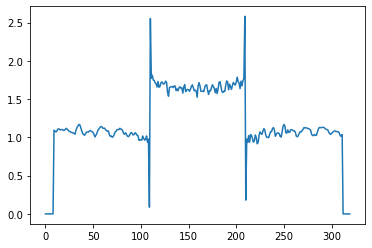

In [176]:
plt.plot(reconstruction_img[110])